# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

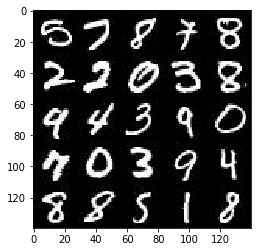

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

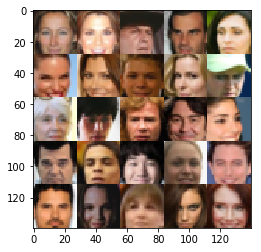

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        bn2 = tf.layers.batch_normalization(x2, training=True, 
                                            scale=False)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.02
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128, 
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train, 
                                           scale=False)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        x2 = tf.layers.batch_normalization(x2, training=is_train, 
                                           scale=False)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.025))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable weights and biases
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Update weights with AdamOptimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_dim, z_dim, beta1):
        
        self.input_real, self.input_z, self.learning_rate = model_inputs(*real_dim, z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_dim[2])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    print_every = 10
    show_every = 100
    n_images = 16
    steps = 0
        
    # init GAN instance via class defined above
    image_shape = data_shape[1:]
    gan = GAN(image_shape, z_dim, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                               
                # TODO: Train Model
                steps +=1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Run optimizers
                # we also feed input_real to g_opt only to respect tf.control_dependencies block in model_opt
                _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_images, 
                                                   gan.input_z: batch_z, 
                                                   gan.learning_rate: learning_rate})
                _ = sess.run(gan.g_opt, feed_dict={gan.input_z: batch_z, 
                                                   gan.input_real: batch_images, 
                                                   gan.learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # Print losses each epoch
                    train_loss_d = gan.d_loss.eval({gan.input_real: batch_images, gan.input_z: batch_z})
                    train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Discriminator Loss: {:.4f}...".format(train_loss_d), 
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, gan.input_z, image_shape[2], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 0.2508... Generator Loss: 2.1289
Epoch 1/2... Discriminator Loss: 0.2002... Generator Loss: 1.9066
Epoch 1/2... Discriminator Loss: 0.1527... Generator Loss: 2.6448
Epoch 1/2... Discriminator Loss: 0.3135... Generator Loss: 5.5339
Epoch 1/2... Discriminator Loss: 0.4732... Generator Loss: 1.7959
Epoch 1/2... Discriminator Loss: 0.4700... Generator Loss: 2.3291
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 0.8990
Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 1.7993


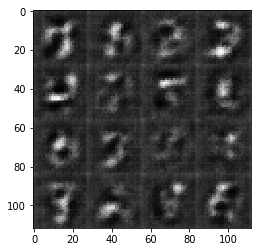

Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 2.0038
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 2.9540
Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 2.2047
Epoch 1/2... Discriminator Loss: 0.6149... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 0.5172... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.3501


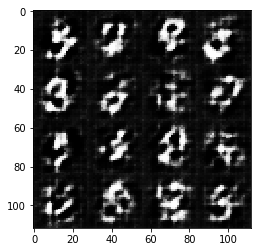

Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.3052
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 0.7079... Generator Loss: 1.1598
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 2.1933
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 0.6261... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 0.7568... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 0.8380


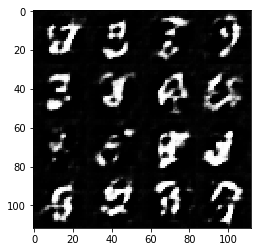

Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 2.4524
Epoch 1/2... Discriminator Loss: 0.6539... Generator Loss: 1.6518
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.1386
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 0.9512
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.4889
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 0.9455


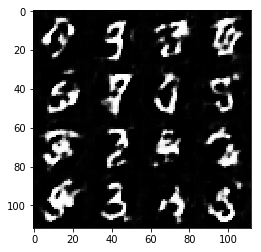

Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.3245
Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.4244
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.2756
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 0.9703
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 0.9039


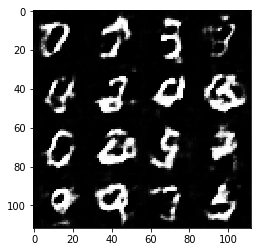

Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 0.6766... Generator Loss: 1.2198
Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.7802
Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 1.3955
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 0.6497... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 0.5071... Generator Loss: 2.0132
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 1.5530
Epoch 1/2... Discriminator Loss: 0.8293... Generator Loss: 0.8521


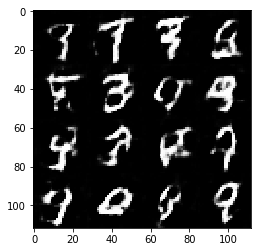

Epoch 1/2... Discriminator Loss: 0.7137... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.3834
Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 0.6428... Generator Loss: 1.3456
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.0358
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 0.6500... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 0.6804... Generator Loss: 1.1633


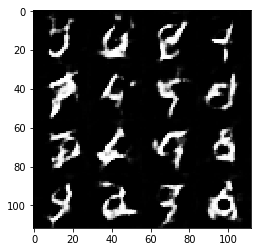

Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.5777
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.2955
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.9528
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 2.1681
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 1.0362


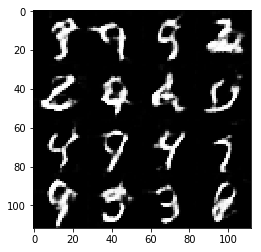

Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.7177
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.7016
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.1297
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 1.6232


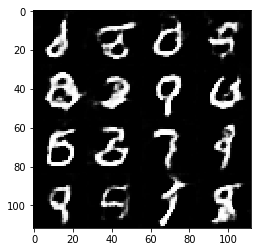

Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.0590
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 0.8375... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 0.7984... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 2.0293... Generator Loss: 0.1961
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.8617


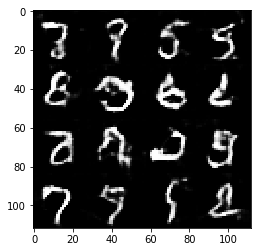

Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.4471
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.2131
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 0.8250


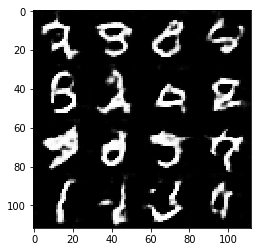

Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 2.0574
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 3.3347
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 1.3112
Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 0.5724
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.6778


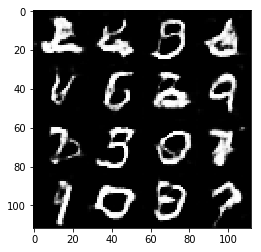

Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.0329
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.2291
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.6159
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 3.0814
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.1443


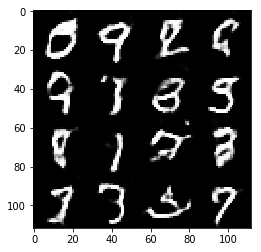

Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.4474
Epoch 2/2... Discriminator Loss: 0.7004... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: 1.6889... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.0777


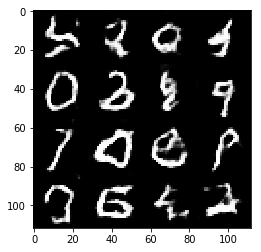

Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 0.6047... Generator Loss: 1.3247
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 4.4609... Generator Loss: 6.0292
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.7211
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 0.8006


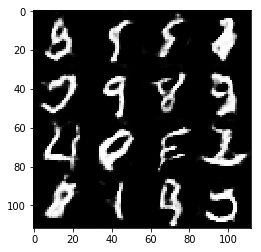

Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.3845
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 1.5677
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 1.6566
Epoch 2/2... Discriminator Loss: 0.7069... Generator Loss: 1.3355


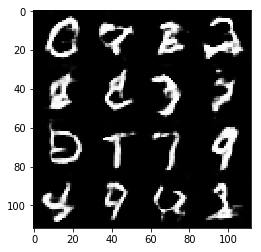

Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 4.7928... Generator Loss: 5.9407
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 0.6460... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.4506
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 2.0767


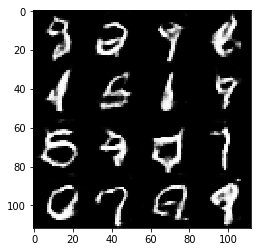

Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 1.4476
Epoch 2/2... Discriminator Loss: 0.5914... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.6509... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 1.1602
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.3432


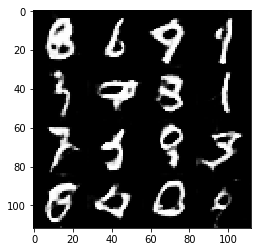

Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 1.2931
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 1.4757
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 0.4857... Generator Loss: 2.3132
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 0.9975


In [13]:
batch_size = 64
z_dim = 200
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.0700
Epoch 1/1... Discriminator Loss: 0.1277... Generator Loss: 3.5902
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 2.2805
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.3739
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.2765


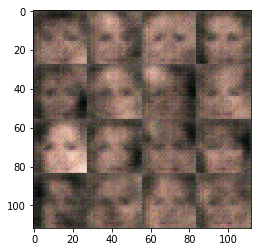

Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.8900
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.5565
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.5689


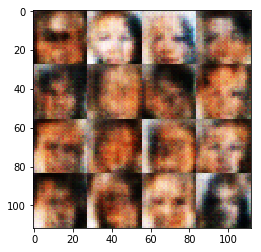

Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.4658


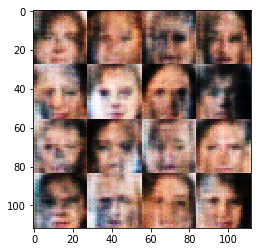

Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 2.7978
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.5225


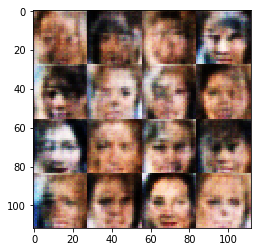

Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.8835
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.9163
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.5910
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.1408


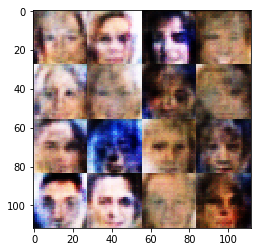

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 2.0990
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.5044
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.3354
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.0675


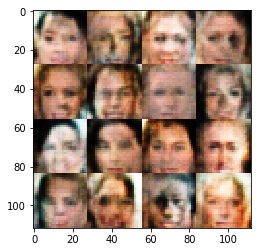

Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 1.8314
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 2.3199


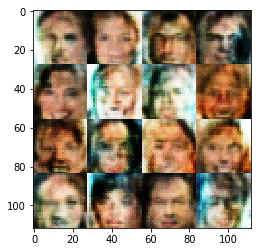

Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 3.1032
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 3.1300


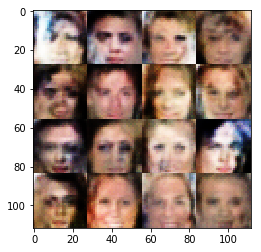

Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.9149
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 2.0362
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.0664


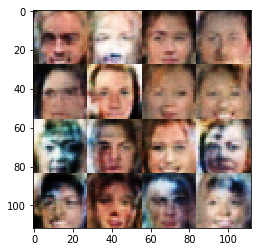

Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.3555
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.8294


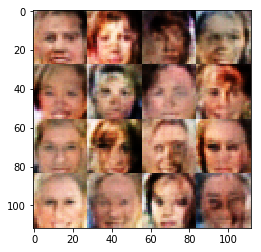

Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.2033
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 1.6926


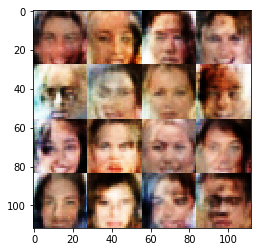

Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 3.5041
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.7500


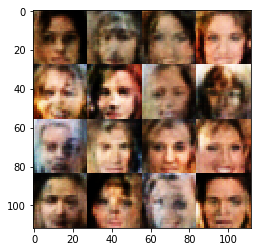

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.9604
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.3955


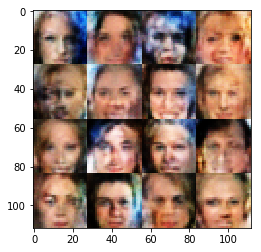

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 3.4608
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 2.7068
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.6174


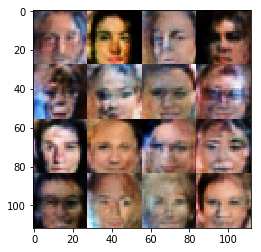

Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.7605


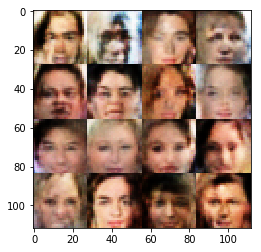

Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.6263
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.6711


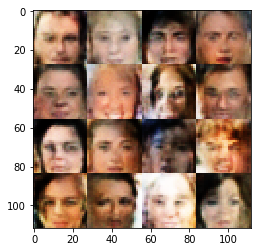

Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.2862
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.0358


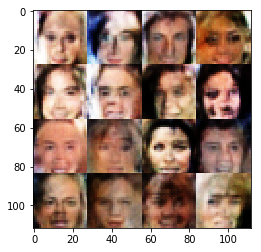

Epoch 1/1... Discriminator Loss: 2.6139... Generator Loss: 0.1066
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8565


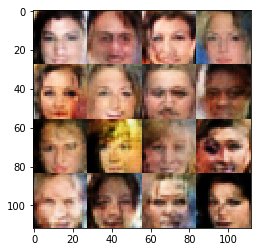

Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.6206
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.2846
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 1.8881... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.7127


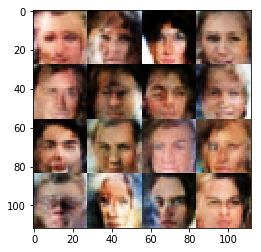

Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 0.2460
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 1.8984
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3428


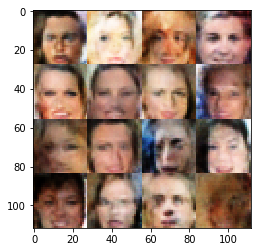

Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.3469
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.7262
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.8021


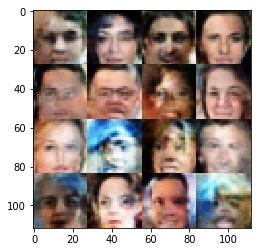

Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.0865


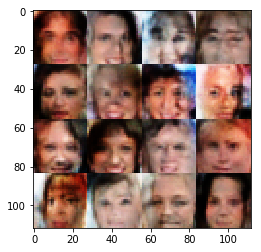

Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.8409


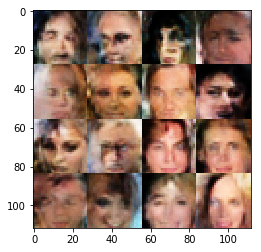

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 2.4594... Generator Loss: 0.1275
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 2.0356
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.1415


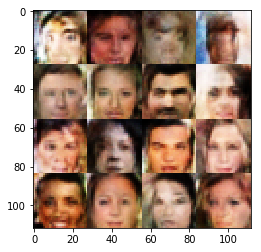

Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.7762
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.4122


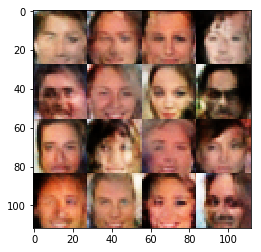

Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.4888
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.3122


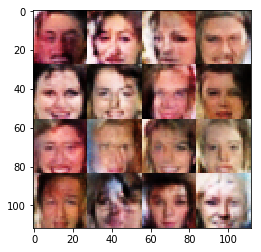

Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.9380... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.7959
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.0584


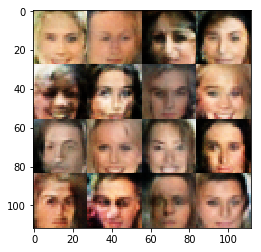

Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.1268


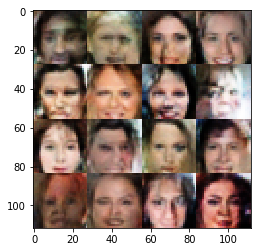

Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5848


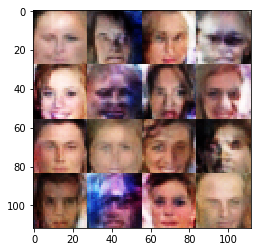

Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.9838
Epoch 1/1... Discriminator Loss: 1.8973... Generator Loss: 0.1995
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.5452


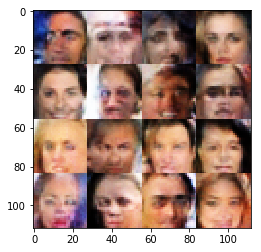

Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 1.9295
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.2465


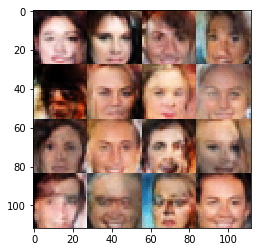

Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 2.2214
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.5331
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.9799


In [14]:
batch_size = 64
z_dim = 200
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.